# Introduction
The goal of this notebook is to give an example of how a scientist could load the HOTS Shipboard ADCP data into a python environment for analysis use. 
1. Setup/bookkeeping
2. We handle loading the data both in the way the python netCDF library and pycurrents would handle it.
3. Then we show some common plots that may be desired.
4. Then we do a time series comparison

## Next Steps/Uses
For a user 
* Find an interesting trend in the data you want to explore
* Learn more about ocean currents via shipboard ADCP data
* Explore more data sets like the ones found in the discussion for the dataset https://www.kaggle.com/datasets/davidvadnais/hawaii-ocean-times-series-shipboard-adcp-data/discussion/543470

For this workbook
* We still need to make sure all the cruises in kaggle_pull_data and web_pull_data work.
* Make an actually interesting correlation data point or trend for users to build on top of
* Demonstrate more of pycurrents capabilities 


## Example papers that use shipboard ADCP data
Alcaraz, Nicholas. Spatial Assessment of Antarctic Krill (Euphausia superba) in the Palmer Long-Term Ecological Research (LTER) Study Site using Acoustic Doppler Current Profiler (ADCP) Technology. Diss. Duke University, 2017.

Erickson, Z. K., Fields, E., Johnson, L., Thompson, A. F., Dove, L. A., D’Asaro, E., & Siegel, D. A. (2023). Eddy tracking from in situ and satellite observations. Journal of Geophysical Research: Oceans, 128(8), e2023JC019701. https://doi.org/10.1029/2023JC019701

Firing, E and Hummon, J. M. (2010) Shipboard ADCP Measurements. In, The GO-SHIP Repeat Hydrography Manual: A Collection of Expert Reports and Guidelines. Version 1, (eds Hood, E.M., C.L. Sabine, and B.M. Sloyan). 11pp. (IOCCP Report Number 14; ICPO Publication Series Number 134). Available online at: http://www.go-ship.org/HydroMan.html. DOI: https://doi.org/10.25607/OBP-1352

Firing, J. U. N. E., and Russell E. Brainard. "Ten years of shipboard ADCP measurements along the Northwestern Hawaiian Islands." Atoll research bulletin (2006).

James, A. K., Washburn, L., Gotschalk, C., Maritorena, S., Alldredge, A., Nelson, C. E., ... & Carlson, C. A. (2020). An island mass effect resolved near Mo’orea, French Polynesia. Frontiers in Marine Science, 7, 16.

Lund, B., Graber, H. C., Hessner, K., & Williams, N. J. (2015). On Shipboard Marine X-Band Radar Near-Surface Current ‘‘Calibration’’. Journal of Atmospheric and Oceanic Technology, 32(10), 1928-1944. https://doi.org/10.1175/JTECH-D-14-00175.1

Marshall, T., Granger, J., Casciotti, K.L. et al. The Angola Gyre is a hotspot of dinitrogen fixation in the South Atlantic Ocean. Commun Earth Environ 3, 151 (2022). https://doi.org/10.1038/s43247-022-00474-x

Petit T, Mercier H., Thierry  V. First Direct Estimates of Volume and Water Mass Transports Across the Reykjanes Ridge  29 August 2018
https://doi.org/10.1029/2018JC013999

Sabine Haalboom, Henko C. de Stigter, Christian Mohn, Thomas Vandorpe, Marck Smit, Laurens de Jonge, Gert-Jan Reichart,
Monitoring of a sediment plume produced by a deep-sea mining test in shallow water, Málaga Bight, Alboran Sea (southwestern Mediterranean Sea),
Marine Geology,Volume 456,2023,106971,ISSN 0025-3227,https://doi.org/10.1016/j.margeo.2022.106971. (https://www.sciencedirect.com/science/article/pii/S0025322722002420)

Sloyan, Bernadette M., et al. "The global ocean ship-based hydrographic investigations program (GO-SHIP): a platform for integrated multidisciplinary ocean science." Frontiers in Marine Science 6 (2019): 445.

Vijith, V., Vinayachandran, P.N., Webber, B.G.M. et al. Closing the sea surface mixed layer temperature budget from in situ observations alone: Operation Advection during BoBBLE. Sci Rep 10, 7062 (2020). https://doi.org/10.1038/s41598-020-63320-0

WangY.H. et al. Transports and tidal current estimates in the Taiwan Strait from shipboard ADCP observations (1999–2001)
Estuar. Coast. Shelf Sci. (2003)

Whelan, Sean P., et al. "WHOI Hawaii ocean timeseries station (WHOTS)." Massachusetts: Woods Hole Oceanographic Institution (2010).

Zhang, Yanwu, et al. "Autonomous tracking and sampling of the deep chlorophyll maximum layer in an open-ocean eddy by a long-range autonomous underwater vehicle." IEEE Journal of Oceanic Engineering 45.4 (2019): 1308-1321.

Zhang, Yingjun, et al. "Physical characteristics and evolution of a long-lasting mesoscale cyclonic eddy in the Straits of Florida." Frontiers in Marine Science 9 (2022): 779450.

## Linked references/Further reading
**This is the main document we are pulling from**<br>
Julia M Hummon, et al. CODAS+UHDAS Documentation. 282:c289b3782d3a, Zenodo, 22 Sept. 2023, doi:10.5281/zenodo.8371260.

**Shameless hamfisted self reference**<br>
Vadnais, David, Michael Middleton, and Oluwatosin Oluwadare. "ParticleChromo3D: a Particle Swarm Optimization algorithm for chromosome 3D structure prediction from Hi-C data." BioData Mining 15.1 (2022): 19.

Vadnais, David, and Oluwatosin Oluwadare. "ParticleChromo3D+: a web server for ParticleChromo3D algorithm for 3D chromosome structure reconstruction." Current Issues in Molecular Biology 45.3 (2023): 2549-2560.

# 1. Setup
the codas and pycurrents install is abriged from the [CODAS+UHDAS Documentation](https://currents.soest.hawaii.edu/docs/adcp_doc/codas_setup/codas_config/index.html) 

In [1]:
%%capture cell_output
# We have surpressed the output of this cell for clarity. The waf build is verbose and not the focus of this notebook
!pip install netCDF4 mercurial

# Clone mercurial repos of codas and pycurrents
!hg clone https://currents.soest.hawaii.edu/hg/codas3
!hg clone https://currents.soest.hawaii.edu/hg/pycurrents

# Install codas3 then pycurrents
!cd codas3 && ./waf configure --python_env && ./waf build &&./waf install
!cd pycurrents && pip install .

In [2]:
import requests
import netCDF4 as nc
import io
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pycurrents.adcp.panelplotter as pp
import numpy as np
import math 
from scipy.stats import spearmanr, pearsonr

In [3]:
# Constants
target_url_front = "https://currents.soest.hawaii.edu/hot/downloads/"
target_url_end_list = ["_short.nc","_tide_PO.nc","_tpxo72.nc"]
cruise_limit = 1000 # to get all cruises just set to greater then the ~300 cruises
data_loc = '/kaggle/input/hawaii-ocean-times-series-shipboard-adcp-data/data'

In [4]:
# Fetch the webpage
url = "https://currents.soest.hawaii.edu/hot/global_list/0/index.html"
response = requests.get(url)
html_content = response.content

# Parse the webpage with BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find all rows containing cruise and sonar info
rows = soup.find_all('tr')[1:]  # Skip header row

# Extract cruise names and sonar details
cruise_sonar_pairs = []
for row in rows: 
    cols = row.find_all('td')
    cruise_name = cols[1].text.strip()
    sonar_info = cols[4].text.strip()  # sonar info is in the 5th column
    cruise_sonar_pairs.append([cruise_name, sonar_info])
    #print(f"Cruise Name: {cruise_name}, Sonar: {sonar_info}")

In [5]:
#https://stackoverflow.com/questions/51839764/iterate-through-directory-until-a-specific-folder-name-is-found
#see kaggle data hot011. Some of the cruises have the instrument name before the contour directory
def find_directory(start_path, target_dir_name):
    
    for root, dirs, files in os.walk(data_loc + '/' +start_path):
        if target_dir_name in dirs:
            return os.path.join(root, target_dir_name)
    return None

#/kaggle/input/hawaii-ocean-times-series-shipboard-adcp-data/data/hot154/os38nb/contour/hot154_os38bb_short.nc


In [6]:
# load in the hots short form data from the UH website. This will be the most up to date but will be slower.
def web_pull_data(cruise_limit, model=0):
    cruises = []
    index = 0
    target_url_end = target_url_end_list[model]
    for pair in cruise_sonar_pairs:
        sonars = pair[1].replace(' ', '').split(',')
        for sonar in sonars:
            target_url = f"{target_url_front}{pair[0]}_{sonar}{target_url_end}"
            #print(url)
            
            # Download the file data using requests
            response = requests.get(target_url)
            
            # Create an in-memory binary stream from the content
            file_stream = io.BytesIO(response.content)
            
            # Open the NetCDF dataset from the in-memory stream
            ds = nc.Dataset('in_memory_file', memory=file_stream.read())
            
            cruises.append(ds)
    
        if index == cruise_limit:
            break
        index += 1

    return cruises

In [7]:
''' 
faster then a web pull grabs all data places it into netcdf format and pycurrents format for later analysis

TODO see hot011 wild card **/contour
'''
def kaggle_pull_data(cruise_limit,model=0):
    
    #print(os.listdir(data_loc))
    cruises = []
    cruises_pycurrents = []
    index = 0
    target_url_end = target_url_end_list[model]
    for pair in cruise_sonar_pairs:
        sonars = pair[1].replace(' ', '').split(',')
        for sonar in sonars:
            front_of_path = data_loc+'/'+pair[0]+'/'+'contour'
            #Deal with broadband/narrowband / multi sensors
            if not Path(front_of_path).is_dir():
                front_of_path = data_loc+'/'+pair[0]+'/'+sonar+'/'+'contour'
                
            target_loc = f"{front_of_path}/{pair[0]}_{sonar}{target_url_end}"
            #print(target_loc)
            
            # load the nc file
            ds = nc.Dataset(target_loc,'r')
            
            cruises.append(ds)

            ds = pp.get_data(target_loc)
            
            cruises_pycurrents.append(ds)
    
        if index == cruise_limit:
            break
        index += 1

    return cruises, cruises_pycurrents


# 2. Load the data

In [8]:
cruise_list_nc, cruise_list_pycurrents = kaggle_pull_data(500)

Now that we have loaded our data into memory lets look at it.

**NetCDF** <br>
We see for cruise hot001 we had 1231 times stamps and 62 depth cells.  
* The depth cell count will dependent on instrument and cruise settings 
* The time cell count will depend on cruise length (time) and cruise settings

We could now have some fun doing things like showing velocity by depth

In [9]:
# showing a netcdf data block
cruise_list_nc[0]

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    featureType: trajectoryProfile
    history: Created: 2020-03-23 22:52:58 UTC
    Conventions: COARDS
    software: pycurrents
    hg_changeset: 0:19eeb20e632a
    title: Shipboard ADCP velocity profiles
    description: Shipboard ADCP velocity profiles from hot001 using instrument nb150 - Short Version.
    cruise_id: hot001
    sonar: nb150
    yearbase: 1988
    dimensions(sizes): time(1231), depth_cell(62)
    variables(dimensions): int32 trajectory(), float64 time(time), float64 lon(time), float64 lat(time), float32 depth(time, depth_cell), float32 u(time, depth_cell), float32 v(time, depth_cell), int16 amp(time, depth_cell), int8 pg(time, depth_cell), int8 pflag(time, depth_cell), float32 heading(time), float32 tr_temp(time), int16 num_pings(time), float32 uship(time), float32 vship(time)
    groups: 

# 3. Plotting 
## First lets create a basic plot

Variables in the dataset: ['dday', 'yearbase', 'lon', 'lat', 'depth', 'u', 'v', 'amp', 'pg', 'pflag', 'heading', 'tr_temp', 'num_pings', 'uship', 'vship', 'spd']


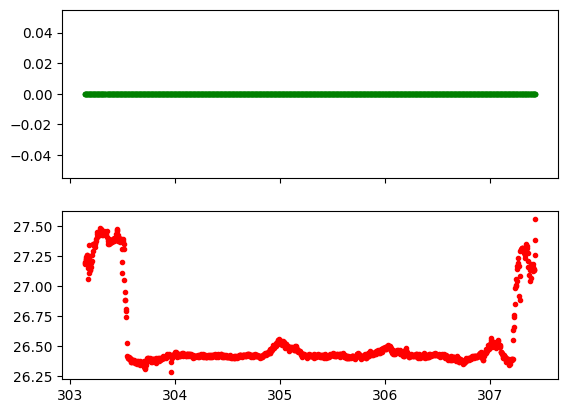

In [10]:
# this cell is just demonstrating basic plotting
variables = list(cruise_list_pycurrents[-1].keys())
print("Variables in the dataset:", variables)

# example plot heading over time
f,ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(cruise_list_pycurrents[0].dday, cruise_list_pycurrents[0].heading, 'g.')
ax[1].plot(cruise_list_pycurrents[0]['dday'], cruise_list_pycurrents[0]['tr_temp'],'r.')
plt.show()

## Now lets create a standard U,V plot
This plot is described in the [UHDAS docs](https://currents.soest.hawaii.edu/docs/adcp_doc/UHDAS_OPERATIONS/UHDAS_atsea/web-site-tour/index.html#right-side-science-plots) 

**Key Data** <br>
profile flag is a 3 bit bitmask [range, % good, bin]<br>
pg is percent good and it is an integer from 0-100

/opt/conda/lib/python3.10/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


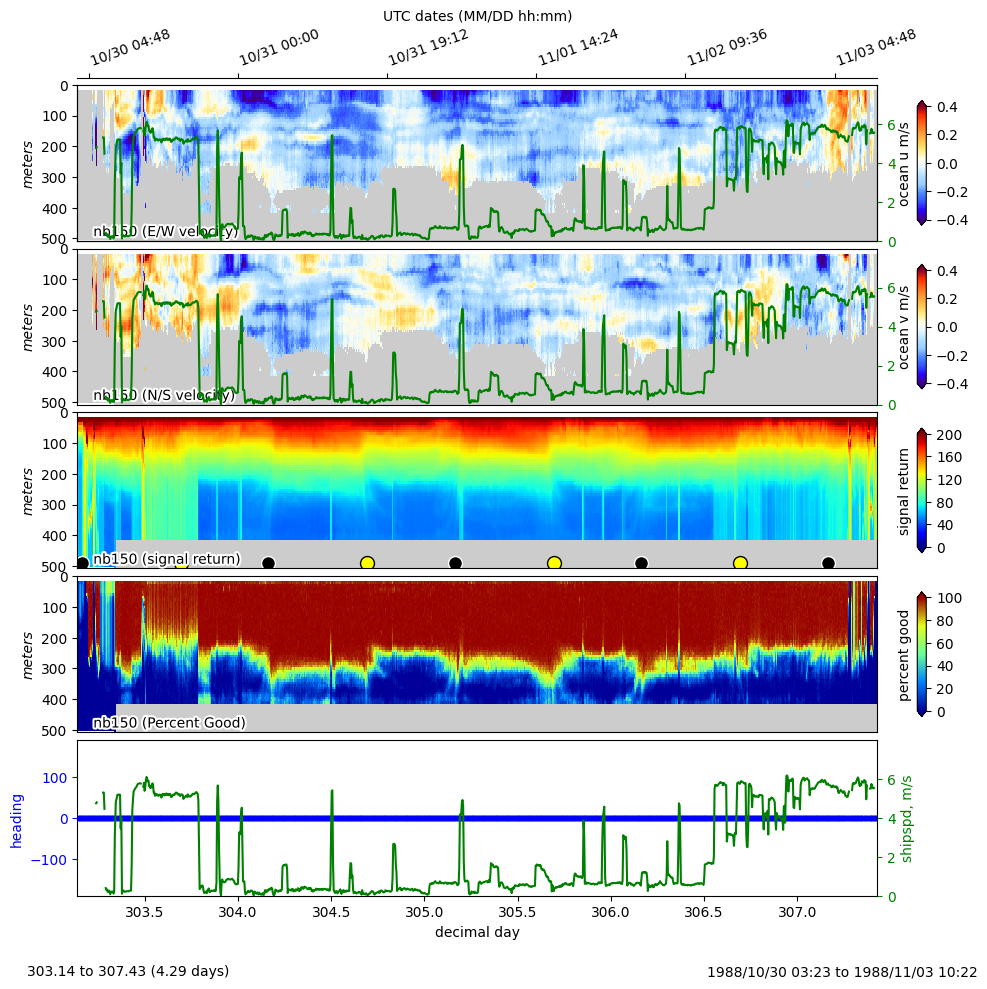

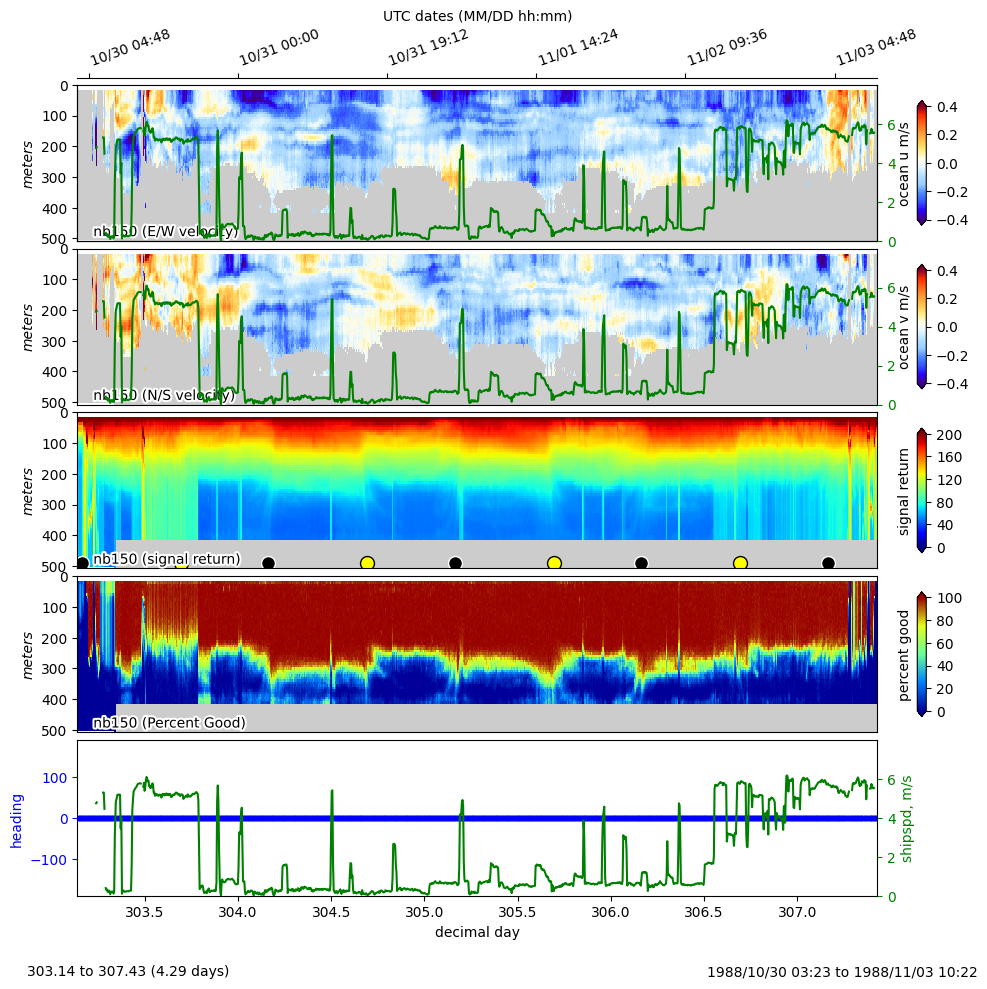

In [11]:
data = cruise_list_pycurrents[0]

# our first problem is we have data without the percent good masked so lets clear that
# remove low ping ensemble returns 
percent_good_cutoff = 30 # 30% cutoff
percent_good_bit = 2

condition = data.pg < percent_good_cutoff
# Activate the 2nd bit using bitwise OR
data.pflag[condition] |= percent_good_bit 
data.u.mask[condition] = True
data.v.mask[condition] = True


# plot data
ncdata2 = pp.NCData(data)
ncdata2.set_grid()
pp.plot_data(ncdata2, speed=True, sonar="nb150", add_suntimes = True, add_utc=True)

# 4. Time series example

*Please keep in mind this is an example and it would not be a good idea to do this comparison with so many instruments reaching different depths, seasonality ignored, etc.*
## Plotting

/opt/conda/lib/python3.10/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_17/1938231045.py:4: RuntimeWarning: invalid value encountered in sqrt
  magnitudes = np.sqrt(cruise.u**2 + cruise.v**2)


Text(0.5, 1.0, 'Scatter Plot of Average Speed vs. Cruise')

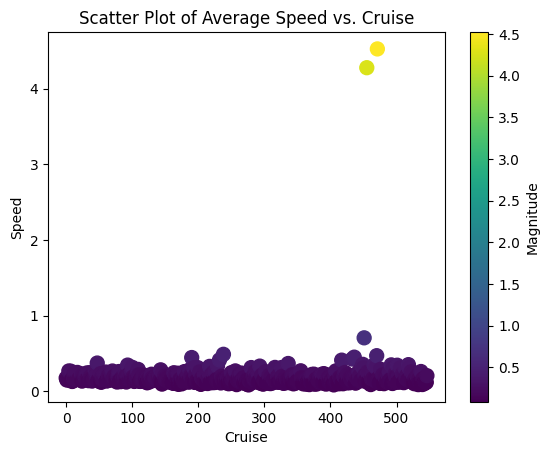

In [12]:
cruise_average_velocity = []
for cruise in cruise_list_pycurrents: 
    # Calculate magnitude for each pair of x and y speeds
    magnitudes = np.sqrt(cruise.u**2 + cruise.v**2)
    cruise_average_velocity.append(np.mean(magnitudes))


# Scatter plot with y values as the index (1, 2, 3,...)
plt.scatter(range(len(cruise_average_velocity)), cruise_average_velocity, c=cruise_average_velocity, cmap='viridis', s=100)

# Add a color bar to show the magnitude scale
plt.colorbar(label='Magnitude')

# Labels and title
plt.xlabel('Cruise')
plt.ylabel('Speed')
plt.title('Scatter Plot of Average Speed vs. Cruise')
    

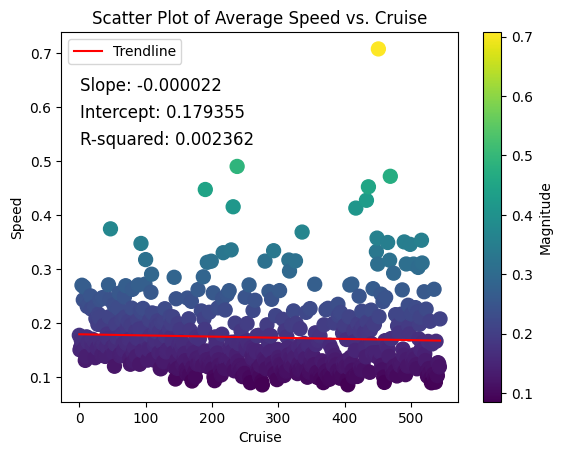

In [13]:
# we have 2 outlier points
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(cruise_average_velocity, 25)
Q3 = np.percentile(cruise_average_velocity, 75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for non-outliers
lower_bound = math.floor(Q1 - 1.5 * IQR)
upper_bound = math.ceil(Q3 + 1.5 * IQR)

# Filter the data to remove outliers
cruise_average_velocity_np = np.array(cruise_average_velocity)
filtered_data = cruise_average_velocity_np[(cruise_average_velocity_np >= lower_bound) & (cruise_average_velocity_np <= upper_bound)]

# Scatter plot with y values as the index (1, 2, 3,...)
plt.scatter(range(len(filtered_data)), filtered_data, c=filtered_data, cmap='viridis', s=100)

# Add a color bar to show the magnitude scale
plt.colorbar(label='Magnitude')

# Fit a linear trendline (1st degree polynomial)
coefficients = np.polyfit(range(len(filtered_data)), filtered_data, 1)  # 1 indicates a linear fit
trendline = np.poly1d(coefficients)

# Generate x values for the trendline
x_trendline = range(len(filtered_data))

# Plot the trendline
plt.plot(x_trendline, trendline(x_trendline), color='red', label='Trendline')

# Calculate R-squared value
y_pred = trendline(x_trendline)  # Predicted y values from the trendline
residuals = filtered_data - y_pred  # Residuals
ss_residual = np.sum(residuals**2)  # Sum of squares of residuals
ss_total = np.sum((filtered_data - np.mean(filtered_data))**2)  # Total sum of squares
r_squared = 1 - (ss_residual / ss_total)  # R-squared formula

# Get slope and intercept
slope = coefficients[0]
intercept = coefficients[1]

# Add trendline stats to the plot
just_under_legend = 0.63
one_row_down = 0.05
plt.text(1, just_under_legend, f"Slope: {slope:.6f}", fontsize=12, color='black')
plt.text(1, just_under_legend-one_row_down, f"Intercept: {intercept:.6f}", fontsize=12, color='black')
plt.text(1, just_under_legend-2*one_row_down, f"R-squared: {r_squared:.6f}", fontsize=12, color='black')

# Labels and title
plt.xlabel('Cruise')
plt.ylabel('Speed')
plt.title('Scatter Plot of Average Speed vs. Cruise')

# Show the legend
plt.legend()

# Display the plot
plt.show()

## Correlation
Alternatively we can show the correlation between data like velocity and cruise.<br>

Spearman and Pearson correlation are described in the paper [ParticleChromo3D: a Particle Swarm Optimization algorithm for chromosome 3D structure prediction from Hi-C data](https://link.springer.com/article/10.1186/s13040-022-00305-x) in the "Metrics used for evaluation" section and the follow paper [ParticleChromo3D+: A Web Server for ParticleChromo3D Algorithm for 3D Chromosome Structure Reconstruction](https://www.mdpi.com/1467-3045/45/3/167) 

In [14]:
# Calculate Pearson and Spearman correlation coefficient
correlation_scc, p_value_scc = spearmanr(range(len(filtered_data)), filtered_data)
correlation_pcc, p_value_pcc = pearsonr(range(len(filtered_data)), filtered_data)


print("Spearman Correlation Coefficient:", correlation_scc)
print("Spearman P-value:", p_value_scc)

print("Pearson Correlation Coefficient:", correlation_pcc)
print("Pearson P-value:", p_value_pcc)

Spearman Correlation Coefficient: -0.17328834144808242
Spearman P-value: 4.7626968830162046e-05
Pearson Correlation Coefficient: -0.04860120431088706
Pearson P-value: 0.2573524791585408
